In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scripts import bookdatafunctions as bdf
from pprint import pprint
from collections import Counter

In [2]:
DATA_FILE_AGES = "Data/FCBLex_data_output_ages.xlsx"
DATA_FILE_GROUPS = "Data/FCBLex_data_output_groups.xlsx"
DATA_FILE_WHOLE = "Data/FCBLex_data_output_whole.xlsx"
SHEET_NAMES_AGES = ['5','6','7','8','9','10','11','12','13','14','15']
SHEET_NAMES_GROUPS = ['7-8','9-12','13+']
WHOLE = 'Whole'
UPOS_TAGS = {'ADJ','ADP','ADV','AUX','CCONJ','INTJ','NOUN','NUM','PRON','PROPN','PUNCT','SCONJ','SYM','VERB'}

In [3]:
dfs_ages = {}
with pd.ExcelFile(DATA_FILE_AGES) as xlsx:
    for sheet in SHEET_NAMES_AGES:
        dfs_ages[sheet] = xlsx.parse(sheet)
dfs_groups = {}
with pd.ExcelFile(DATA_FILE_GROUPS) as xlsx:
    for sheet in SHEET_NAMES_GROUPS:
        dfs_groups[sheet] = xlsx.parse(sheet)
dfs_whole = {}
with pd.ExcelFile(DATA_FILE_WHOLE) as xlsx:
        dfs_whole[WHOLE] = xlsx.parse(WHOLE)

In [ ]:
print(list(dfs_ages.values())[0].columns)

Index(['text', 'lemma', 'upos', 'Word-POS Frequency', 'Word Frequency',
       'Word Zipf', 'Word DP', 'Word CD', 'Lemma Frequency', 'Lemma Zipf',
       'Lemma DP', 'Lemma CD', 'Lemma inflection family size',
       'First Age Encountered'],
      dtype='object')


In [5]:
def formatDataForTable2(dfs, names):
    returnable = {}
    word_amounts = {sheet:dfs[sheet]['Word-POS Frequency'].sum() for sheet in names}
    word_types = {sheet:len(dfs[sheet]['text'].drop_duplicates()) for sheet in names}
    lemma_types = {sheet:len(dfs[sheet]['lemma'].drop_duplicates()) for sheet in names}
    for sheet in names:
        returnable[sheet] = "& "+str(word_amounts[sheet])+" & "+str(word_types[sheet])+" & "+str(lemma_types[sheet])+" \\"
    return returnable

In [6]:
pprint(formatDataForTable2(dfs_groups, SHEET_NAMES_GROUPS), sort_dicts=False)

{'7-8': '& 1485850 & 161730 & 66056 \\',
 '9-12': '& 3787042 & 280798 & 106070 \\',
 '13+': '& 3257675 & 278350 & 108088 \\'}


In [18]:
def formatDataForTable4(dfs, names):
    returnable = {}
    word_amounts = {sheet:dfs[sheet]['Word-POS Frequency'].sum() for sheet in names}
    for tag in UPOS_TAGS:
        text = tag+" "
        for sheet in names:
            df = dfs[sheet]
            text += "& "+str(round(((df[df['upos'] == tag]['Word-POS Frequency'].sum())/word_amounts[sheet])*100, ndigits=1))+" "
        returnable[tag] = text+"\\\\"
    return returnable

In [19]:
temp = list(formatDataForTable4(dfs_groups, SHEET_NAMES_GROUPS).values())
temp.sort()
for i in temp:
    print(i)

ADJ & 5.4 & 4.9 & 5.2 \\
ADP & 1.4 & 1.5 & 1.4 \\
ADV & 8.9 & 9.2 & 8.9 \\
AUX & 6.1 & 6.6 & 6.8 \\
CCONJ & 3.9 & 3.8 & 3.8 \\
INTJ & 0.4 & 0.4 & 0.3 \\
NOUN & 19.6 & 18.2 & 18.9 \\
NUM & 0.7 & 0.5 & 0.9 \\
PRON & 10.1 & 11.5 & 11.1 \\
PROPN & 5.0 & 4.3 & 4.3 \\
PUNCT & 20.3 & 19.4 & 19.7 \\
SCONJ & 2.1 & 2.5 & 2.5 \\
SYM & 0.0 & 0.6 & 0.1 \\
VERB & 15.8 & 16.3 & 15.9 \\


In [20]:
STATISTICAL_TABLE_ROWs = ['M', 'SD', 'Min', 'P10', 'P25', 'P50', 'P75', 'P90', 'Max']
def formatStatisticalData(dfs, column: str, names):
    temp = {}
    for sheet in names:
        stats = []
        data = dfs[sheet][column].to_numpy()
        stats.append(round(np.mean(data), ndigits=2))
        stats.append(np.std(data))
        stats.append(np.min(data))
        stats.append(np.percentile(data, 10))
        stats.append(np.percentile(data, 25))
        stats.append(np.percentile(data, 50))
        stats.append(np.percentile(data, 75))
        stats.append(np.percentile(data, 90))
        stats.append(np.max(data))
        temp[sheet] = stats
    returnable = {}
    for i in range(len(STATISTICAL_TABLE_ROWs)):
        stats = []
        for sheet in names:
            stats.append(temp[sheet][i])
        stats = [str(round(x, ndigits=2)) for x in stats]
        returnable[STATISTICAL_TABLE_ROWs[i]] = (STATISTICAL_TABLE_ROWs[i]+" & "+" & ".join(stats) + " \\\\")
        
    return returnable

In [25]:
temp = list(formatStatisticalData(dfs_groups, 'Lemma CD', SHEET_NAMES_GROUPS).values())
#temp.sort()
for i in temp:
    print(i)

M & 0.23 & 0.25 & 0.25 \\
SD & 0.3 & 0.32 & 0.31 \\
Min & 0.02 & 0.01 & 0.02 \\
P10 & 0.02 & 0.01 & 0.02 \\
P25 & 0.02 & 0.01 & 0.02 \\
P50 & 0.08 & 0.08 & 0.09 \\
P75 & 0.35 & 0.39 & 0.41 \\
P90 & 0.77 & 0.85 & 0.82 \\
Max & 1.0 & 1.0 & 1.0 \\


In [170]:
def getAoAInfo(dfs):
    ages_per_sheet = {}
    for sheet in dfs:
        ages_per_sheet[sheet] = (dfs[sheet]['First Age Encountered'].to_numpy())
    counts = {x:Counter(ages_per_sheet[x]) for x in ages_per_sheet}
    counts_scaled = {x:{y:round(counts[x][y]/len(ages_per_sheet[x]), ndigits=3) for y in counts[x]} for x in counts}
    for s in counts_scaled:
        for a in range(5,16):
            counts_scaled[s].setdefault(a, 0.0)
    return counts_scaled

PLOT_AGES = SHEET_NAMES_AGES
PLOT_COLORS = ['lime','royalblue','brown','deeppink','lightskyblue','darkorange','grey','indigo','tan','purple','cyan']

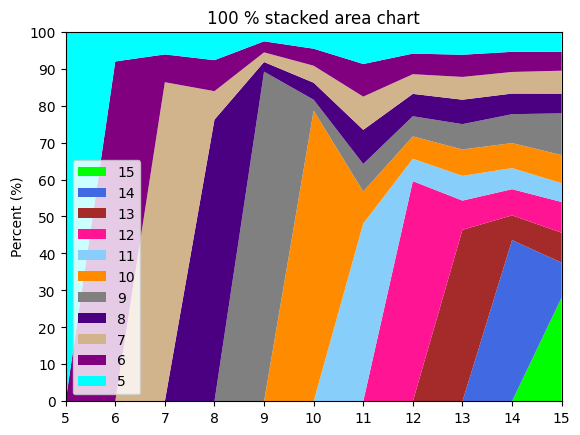

In [171]:
aoa_proportions_ages = getAoAInfo(dfs_ages)
test = [[aoa_proportions_ages[y][x] for x in range(5,16)] for y in aoa_proportions_ages]
for t in test:
    t.reverse()

y = np.row_stack(test)
x = range(5,16)

# Make new array consisting of fractions of column-totals,
# using .astype(float) to avoid integer division
percent = y /  y.sum(axis=0).astype(float) * 100 

fig = plt.figure()
ax = fig.add_subplot(111)

ax.stackplot(x, percent, labels=PLOT_AGES, colors=PLOT_COLORS)
ax.set_title('100 % stacked area chart')
ax.set_ylabel('Percent (%)')
ax.margins(0, 0) # Set margins to avoid "whitespace"
ax.set_xticks(x)
ax.set_yticks(range(0,110,10))
ax.legend()
plt.show()

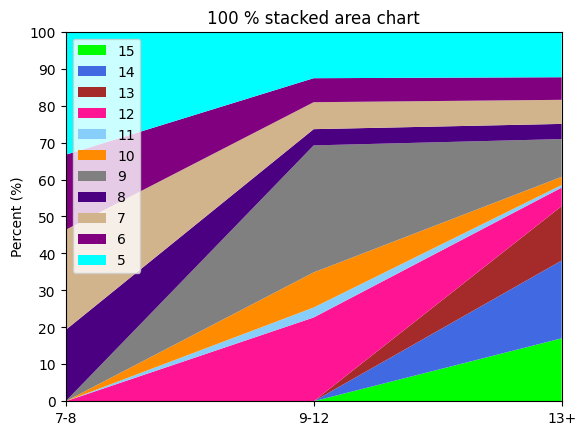

In [172]:
aoa_proportions_groups = getAoAInfo(dfs_groups)
test = [[aoa_proportions_groups[y][x] for x in range(5,16)] for y in aoa_proportions_groups]
for t in test:
    t.reverse()

y = np.column_stack(test)
x = range(0,3)

# Make new array consisting of fractions of column-totals,
# using .astype(float) to avoid integer division
percent = y /  y.sum(axis=0).astype(float) * 100 

fig = plt.figure()
ax = fig.add_subplot(111)

ax.stackplot(x, percent, labels=PLOT_AGES, colors=PLOT_COLORS)
ax.set_title('100 % stacked area chart')
ax.set_ylabel('Percent (%)')
ax.margins(0, 0) # Set margins to avoid "whitespace"
ax.set_xticks(x, labels=SHEET_NAMES_GROUPS)
ax.set_yticks(range(0,110,10))
ax.legend()
plt.show()

[[0.112, 0.068, 0.09, 0.063, 0.191, 0.052, 0.015, 0.125, 0.079, 0.113, 0.092]]


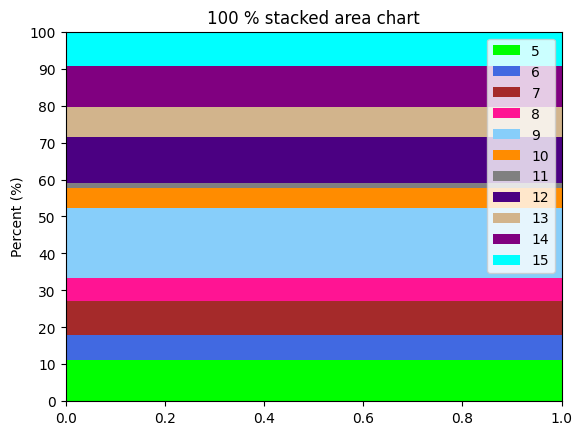

In [177]:
aoa_proportions_whole = getAoAInfo(dfs_whole)
test = [[aoa_proportions_whole[y][x] for x in range(5,16)] for y in aoa_proportions_whole]

print(test)

y = np.column_stack(test)
x = range(0,2)

# Make new array consisting of fractions of column-totals,
# using .astype(float) to avoid integer division
percent = y /  y.sum(axis=0).astype(float) * 100 

fig = plt.figure()
ax = fig.add_subplot(111)

ax.stackplot(x, percent, labels=PLOT_AGES, colors=PLOT_COLORS)
ax.set_title('100 % stacked area chart')
ax.set_ylabel('Percent (%)')
ax.margins(0, 0) # Set margins to avoid "whitespace"
ax.set_yticks(range(0,110,10))
ax.legend()
plt.show()